## Transfer Learning



In [4]:
# Transfer learning is:
# an ML method where a model developed for a first task is then resused as the 
# starting point for a model on a second task

# For example, you can train a model to classify birds and cats and the use the same model,
# and modify only a little bit in the last layer and then use the new model to classify bees and dogs.

# It's a popular approach in Deep Learning that allows rapid generation of new models.
# (It's super important since training a completely-new model can be very time-consuming).

# It can still achieve very good performance results. That's why it is so popular nowadays.

# READ MORE ON THE TOPIC: [VI] https://www.pinecone.io/learn/transfer-learning/

In [5]:
# We're using the pre-tarined ResNet-18 CNN, which was trained on more than 1 million images
# from the ImageNet database. 
# The network is 18 layers deep and can classify images into 1,000 object categories.

# For our example, we only have two classes: we only want to detect bees and ants

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


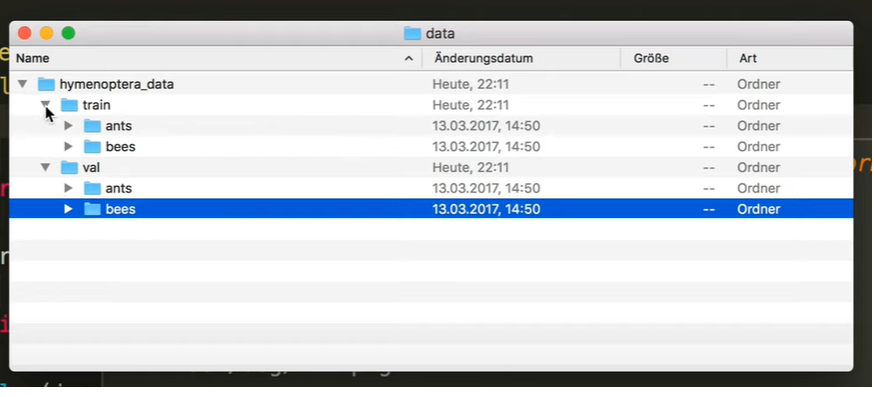

In [9]:
# This is what we expect to have as the data (this is too big and won't be pushed to repo)
# You can download it here: 
# https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqa1RYTFdmdXY3Rm1YNjd5MTJSakNYamtJMWNnd3xBQ3Jtc0tuMUNSaENoZFp5bldJMndsaHk0TmdOTk4tVFFMMDdSLVNlZUQyaEUyOVRkbEVkcm9oZ2FONG9nSmotOTZmU1VVTjQzc0xWbVFpU3VxdWdOSnNNSFpFNWItRFZnLTVJVExqMVJTaUpGYmc3di1KTEZUWQ&q=https%3A%2F%2Fdownload.pytorch.org%2Ftutorial%2Fhymenoptera_data.zip&v=K0lWSB2QoIQ
from IPython.display import Image
Image(filename='15_expected_data.png')

In [10]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['ants', 'bees']


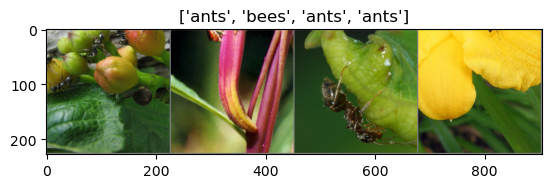

In [12]:
# This is optional - just to visualize the data and get a sense of it
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
#### OPTION 1: Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.
# (PS: For 'finetuning', you are optimizing (changing) the weights for the entire neural network)
# We could also freeze all the previous layers and only train the very last layer (See next one).

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features # number of input features for the last layer
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# PS: it was 25 epochs (it tooks about 23 minutes, so I ran only 4 for a faster example)
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=4)

Epoch 0/3
----------
train Loss: 0.6650 Acc: 0.6311
val Loss: 0.5275 Acc: 0.7386

Epoch 1/3
----------
train Loss: 0.5244 Acc: 0.7582
val Loss: 0.3660 Acc: 0.8627

Epoch 2/3
----------
train Loss: 0.4630 Acc: 0.8033
val Loss: 0.3227 Acc: 0.8758

Epoch 3/3
----------
train Loss: 0.4153 Acc: 0.8156
val Loss: 0.2708 Acc: 0.9020

Training complete in 3m 34s
Best val Acc: 0.901961


In [16]:
# Run the below and compare results
# PS: This will be faster than the previous one (only updating the last layer);
# however, results might not be as good (though, for this case with limited epochs, it was better).

In [18]:
#### OPTION 2: ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# running for only 4 epochs as well for a faster example (it was originally set to 25)
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=4)

Epoch 0/3
----------
train Loss: 0.5895 Acc: 0.6844
val Loss: 0.2602 Acc: 0.9216

Epoch 1/3
----------
train Loss: 0.4136 Acc: 0.7828
val Loss: 0.2205 Acc: 0.9346

Epoch 2/3
----------
train Loss: 0.5563 Acc: 0.7541
val Loss: 0.4319 Acc: 0.8301

Epoch 3/3
----------
train Loss: 0.4096 Acc: 0.8115
val Loss: 0.2689 Acc: 0.8889

Training complete in 2m 20s
Best val Acc: 0.934641
